# Final dataset: yearly postings and demanded people

This notebook loads `final_analysis_dataset.parquet` and reports yearly totals using SJMM weights:
- `srvy_wght_tru1`: truncated ad-level weight (used for job postings counts)
- `srvy_wght_tru2`: truncated weight scaled by employees wanted (used for demanded headcount)

We provide totals for all ads and for ads with `ai_requirement == "True"`, plus weighted shares.

In [6]:
from pathlib import Path
import pandas as pd

# Resolve project root robustly, even when run from the notebook folder
def find_root():
    if "__file__" in globals():
        return Path(__file__).resolve().parents[2]
    cwd = Path.cwd().resolve()
    for q in [cwd] + list(cwd.parents):
        candidate = q / "Results Datasets" / "final_analysis_dataset.parquet"
        if candidate.exists():
            return q
    return cwd

ROOT = find_root()
DATA_PATH = ROOT / "Results Datasets" / "final_analysis_dataset.parquet"

print(f"Loading: {DATA_PATH}")
df = pd.read_parquet(DATA_PATH)

# Keep analysis window explicitly
df = df[(df["adve_time_year"] >= 2010) & (df["adve_time_year"] <= 2024)].copy()

# Consistent dtypes
df["adve_time_year"] = df["adve_time_year"].astype("int64")
df["ai_requirement"] = df["ai_requirement"].astype("string")

print(df.shape)
df.head()

Loading: /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/final_analysis_dataset.parquet
(59794, 95)


,adve_iden_sjob,adve_iden_adve,adve_lang_lang,adve_chan_gene,adve_chan_type,adve_jobn_numb,adve_empl_nraw,adve_empl_nrec,comp_busi_size,comp_sect_publ,...,incu_skil_gene_clean,incu_educ_ide1_clean,incu_educ_ide2_clean,incu_educ_typ1_clean,incu_educ_typ2_clean,incu_educ_yrs1_clean,incu_educ_yrs2_clean,incu_educ_yrsm_clean,adve_empl_nraw_unknown,adve_empl_nraw_clean
0,sjmm_suf-1-01-2010-03-01118-0-000000001-01,sjmm_suf-1-01-2010-03-01118-0-000000001,0,1,1,1,1,1,1,0,...,2,1797,0,3.0,NaN,3.0,NaN,3.00,False,1
1,sjmm_suf-1-01-2010-03-01118-0-000000002-01,sjmm_suf-1-01-2010-03-01118-0-000000002,0,1,1,1,1,1,1,0,...,2,315,0,3.0,NaN,4.0,NaN,4.00,False,1
2,sjmm_suf-1-01-2010-03-01119-0-000000001-01,sjmm_suf-1-01-2010-03-01119-0-000000001,0,1,1,1,999,2,1,1,...,0,0,0,NaN,NaN,NaN,NaN,0.00,True,<NA>
3,sjmm_suf-1-01-2010-03-01120-0-000000001-01,sjmm_suf-1-01-2010-03-01120-0-000000001,0,1,1,1,1,1,2,0,...,2,2059,0,4.0,NaN,4.7,NaN,4.70,False,1
4,sjmm_suf-1-01-2010-03-01120-0-000000002-01,sjmm_suf-1-01-2010-03-01120-0-000000002,0,1,1,1,1,1,1,0,...,2,1371,1413,4.0,5.0,5.0,7.5,6.25,False,1


In [7]:
# Quick sanity checks on key fields
print("Year range:", df["adve_time_year"].min(), df["adve_time_year"].max())
print("ai_requirement counts:", df["ai_requirement"].value_counts(dropna=False))
print("Weights missing (tru1/tru2):", df["srvy_wght_tru1"].isna().sum(), df["srvy_wght_tru2"].isna().sum())


Year range: 2010 2024
ai_requirement counts: ai_requirement
False    56352
Maybe     2961
True       426
<NA>        55
Name: count, dtype: Int64
Weights missing (tru1/tru2): 0 0


In [8]:
def yearly_summary(frame: pd.DataFrame, label: str) -> pd.DataFrame:
    g = frame.groupby("adve_time_year")
    out = pd.DataFrame({
        "postings_unweighted": g.size(),
        "postings_weighted": g["srvy_wght_tru1"].sum(),
        "demand_weighted": g["srvy_wght_tru2"].sum(),
        "group": label,
    })
    return out.reset_index().rename(columns={"adve_time_year": "year"})

all_summary = yearly_summary(df, "all")
ai_true_summary = yearly_summary(df[df["ai_requirement"] == "True"], "ai_requirement=True")

all_summary.head(), ai_true_summary.head()


(   year  postings_unweighted  postings_weighted  demand_weighted group
 0  2010                 4085         72730.7017       80201.1171   all
 1  2011                 4199         91055.1722       96098.3044   all
 2  2012                 4251         92425.5602      101527.7178   all
 3  2013                 4320         94492.2162      102255.5986   all
 4  2014                 3692        100227.6535      107862.6531   all,
    year  postings_unweighted  postings_weighted  demand_weighted  \
 0  2010                    2            17.6729          17.6729   
 1  2011                    4            46.9658          46.9658   
 2  2012                    7           126.9824         144.7322   
 3  2013                   10           146.4547         146.4547   
 4  2014                    7           225.8165         225.8165   
 
                  group  
 0  ai_requirement=True  
 1  ai_requirement=True  
 2  ai_requirement=True  
 3  ai_requirement=True  
 4  ai_requirement=Tr

In [9]:
# Merge to compute AI shares
merged = all_summary.merge(
    ai_true_summary,
    on="year",
    how="left",
    suffixes=("_all", "_ai")
)

for col in ["postings_weighted_ai", "demand_weighted_ai", "postings_unweighted_ai"]:
    if col in merged:
        merged[col] = merged[col].fillna(0)

merged["ai_posting_share"] = merged["postings_weighted_ai"].where(merged["postings_weighted_all"] > 0, 0) / merged["postings_weighted_all"].where(merged["postings_weighted_all"] > 0)
merged["ai_demand_share"] = merged["demand_weighted_ai"].where(merged["demand_weighted_all"] > 0, 0) / merged["demand_weighted_all"].where(merged["demand_weighted_all"] > 0)

merged.sort_values("year")


,year,postings_unweighted_all,postings_weighted_all,demand_weighted_all,group_all,postings_unweighted_ai,postings_weighted_ai,demand_weighted_ai,group_ai,ai_posting_share,ai_demand_share
0,2010,4085,72730.7017,80201.1171,all,2,17.6729,17.6729,ai_requirement=True,0.000243,0.00022
1,2011,4199,91055.1722,96098.3044,all,4,46.9658,46.9658,ai_requirement=True,0.000516,0.000489
2,2012,4251,92425.5602,101527.7178,all,7,126.9824,144.7322,ai_requirement=True,0.001374,0.001426
3,2013,4320,94492.2162,102255.5986,all,10,146.4547,146.4547,ai_requirement=True,0.00155,0.001432
4,2014,3692,100227.6535,107862.6531,all,7,225.8165,225.8165,ai_requirement=True,0.002253,0.002094
5,2015,3703,95716.8056,102542.0088,all,13,270.9298,270.9298,ai_requirement=True,0.002831,0.002642
6,2016,3944,98204.9033,104038.788,all,12,215.8357,248.4234,ai_requirement=True,0.002198,0.002388
7,2017,3894,99701.576,107467.6759,all,29,663.5709,937.9043,ai_requirement=True,0.006656,0.008727
8,2018,4040,104677.2332,113359.3204,all,32,600.2381,642.9381,ai_requirement=True,0.005734,0.005672
9,2019,4086,96636.5573,105048.6306,all,48,883.8259,950.0259,ai_requirement=True,0.009146,0.009044


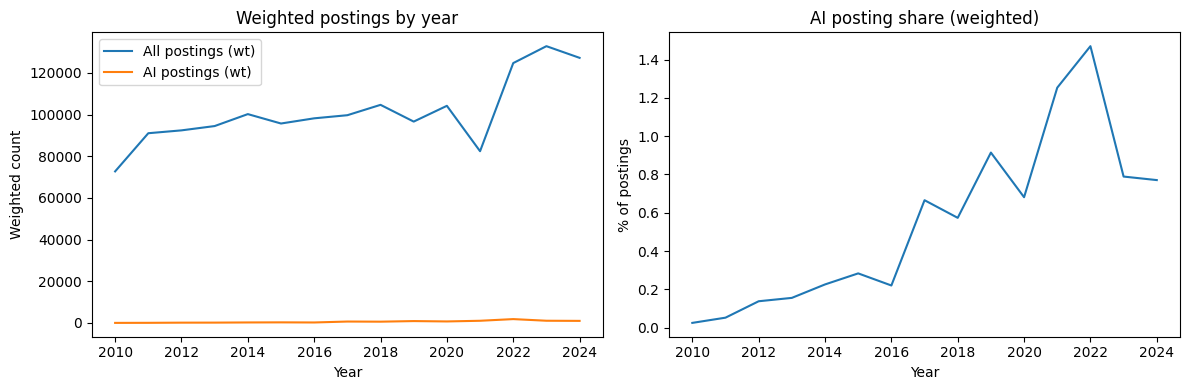

In [10]:
# Optional: simple plots (year vs weighted totals and AI share)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(merged["year"], merged["postings_weighted_all"], label="All postings (wt)")
axes[0].plot(merged["year"], merged["postings_weighted_ai"], label="AI postings (wt)")
axes[0].set_title("Weighted postings by year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Weighted count")
axes[0].legend()

axes[1].plot(merged["year"], merged["ai_posting_share"] * 100)
axes[1].set_title("AI posting share (weighted)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("% of postings")
plt.tight_layout()
plt.show()


## Weighted trends (postings and demanded people)

Plots show weighted totals for all ads vs AI-only, and AI shares, using:
- `srvy_wght_tru1` (postings)
- `srvy_wght_tru2` (demanded people)


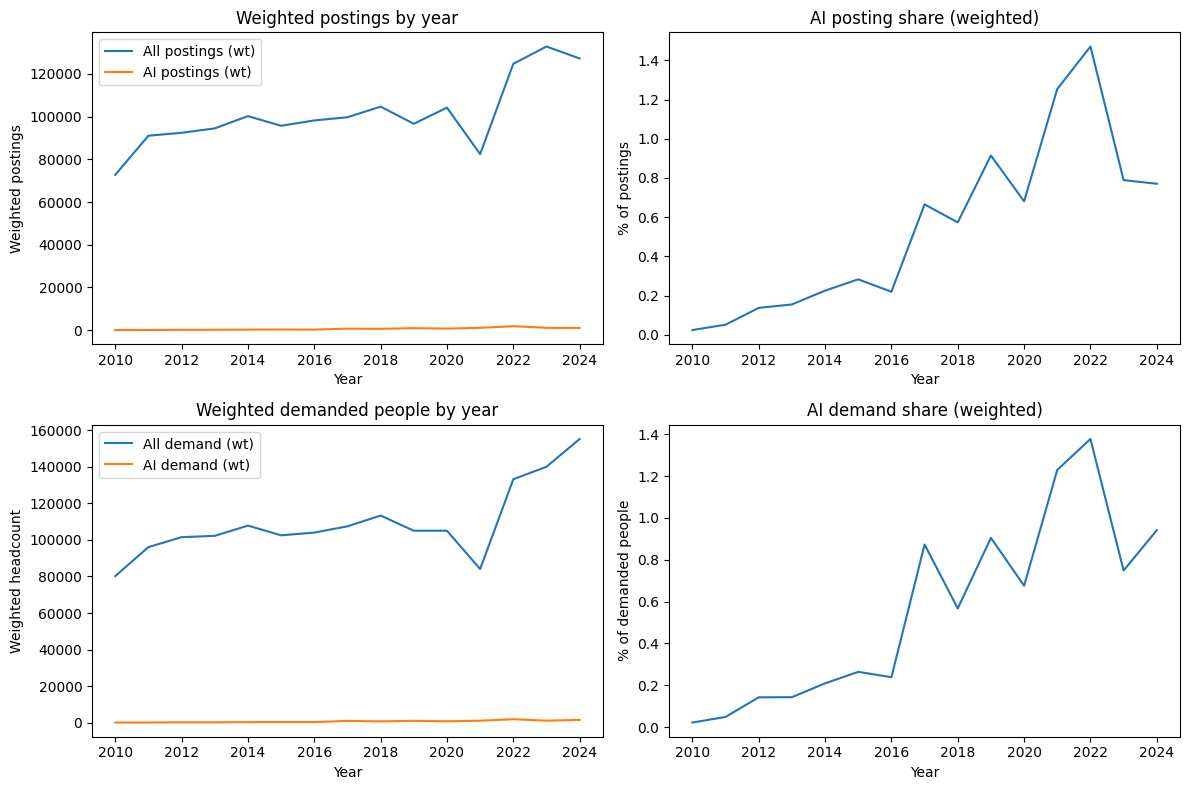

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Postings (weighted)
axes[0,0].plot(merged["year"], merged["postings_weighted_all"], label="All postings (wt)")
axes[0,0].plot(merged["year"], merged["postings_weighted_ai"], label="AI postings (wt)")
axes[0,0].set_title("Weighted postings by year")
axes[0,0].set_xlabel("Year")
axes[0,0].set_ylabel("Weighted postings")
axes[0,0].legend()

# Postings share
axes[0,1].plot(merged["year"], merged["ai_posting_share"] * 100)
axes[0,1].set_title("AI posting share (weighted)")
axes[0,1].set_xlabel("Year")
axes[0,1].set_ylabel("% of postings")

# Demand (weighted)
axes[1,0].plot(merged["year"], merged["demand_weighted_all"], label="All demand (wt)")
axes[1,0].plot(merged["year"], merged["demand_weighted_ai"], label="AI demand (wt)")
axes[1,0].set_title("Weighted demanded people by year")
axes[1,0].set_xlabel("Year")
axes[1,0].set_ylabel("Weighted headcount")
axes[1,0].legend()

# Demand share
axes[1,1].plot(merged["year"], merged["ai_demand_share"] * 100)
axes[1,1].set_title("AI demand share (weighted)")
axes[1,1].set_xlabel("Year")
axes[1,1].set_ylabel("% of demanded people")

plt.tight_layout()
plt.show()
